draw line chart for adj.R2

In [2]:
import pandas as pd

# Load the dataset
data = pd.read_csv("../data/final/reg_results_multi_branch_sample_932466/12MCD10K_reg_results.csv")
data

,month,r2_inst,r2_primarycompany,r2_zip9,r2_zip5,r2_zip3,r2_msa,r2_cbsa,r2_county
0,15-Jan,0.946987,0.860974,0.915455,0.750669,0.422015,0.276968,0.338416,0.353376
1,15-Feb,0.944367,0.858309,0.923690,0.758006,0.442200,0.284489,0.355464,0.369365
2,15-Mar,0.943429,0.851706,0.921819,0.756833,0.461545,0.295927,0.371839,0.387021
3,15-Apr,0.950543,0.844006,0.902994,0.757903,0.486657,0.307334,0.385967,0.390775
4,15-May,0.953993,0.800279,0.904824,0.734719,0.476649,0.279368,0.370662,0.370061
...,...,...,...,...,...,...,...,...,...
104,23-Sep,0.927171,0.913685,0.905125,0.744652,0.472185,0.268940,0.323249,0.387018
105,23-Oct,0.926767,0.908929,0.922848,0.779768,0.484651,0.283825,0.347457,0.402001
106,23-Nov,0.928676,0.890088,0.929197,0.767613,0.465187,0.273557,0.320098,0.384679
107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


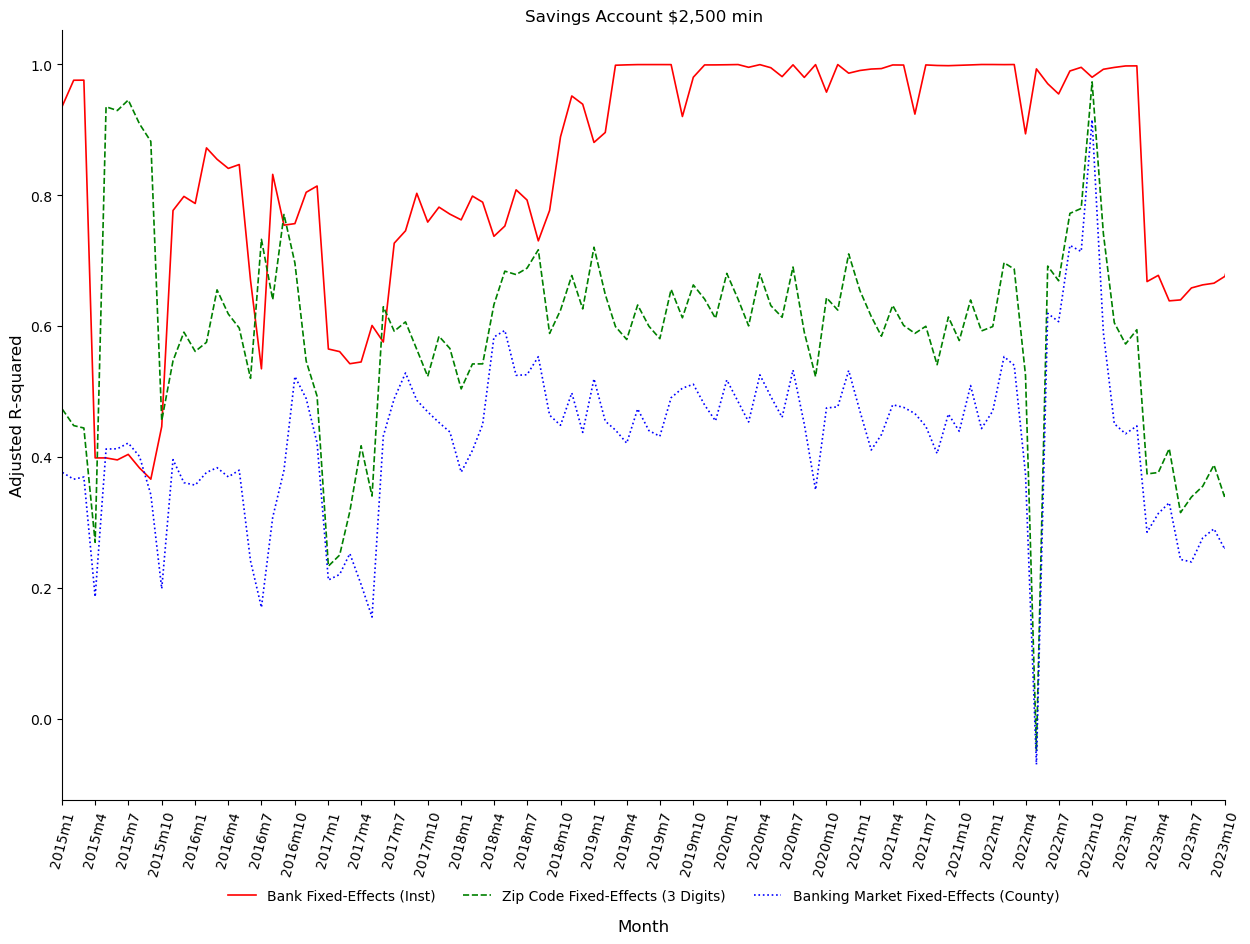

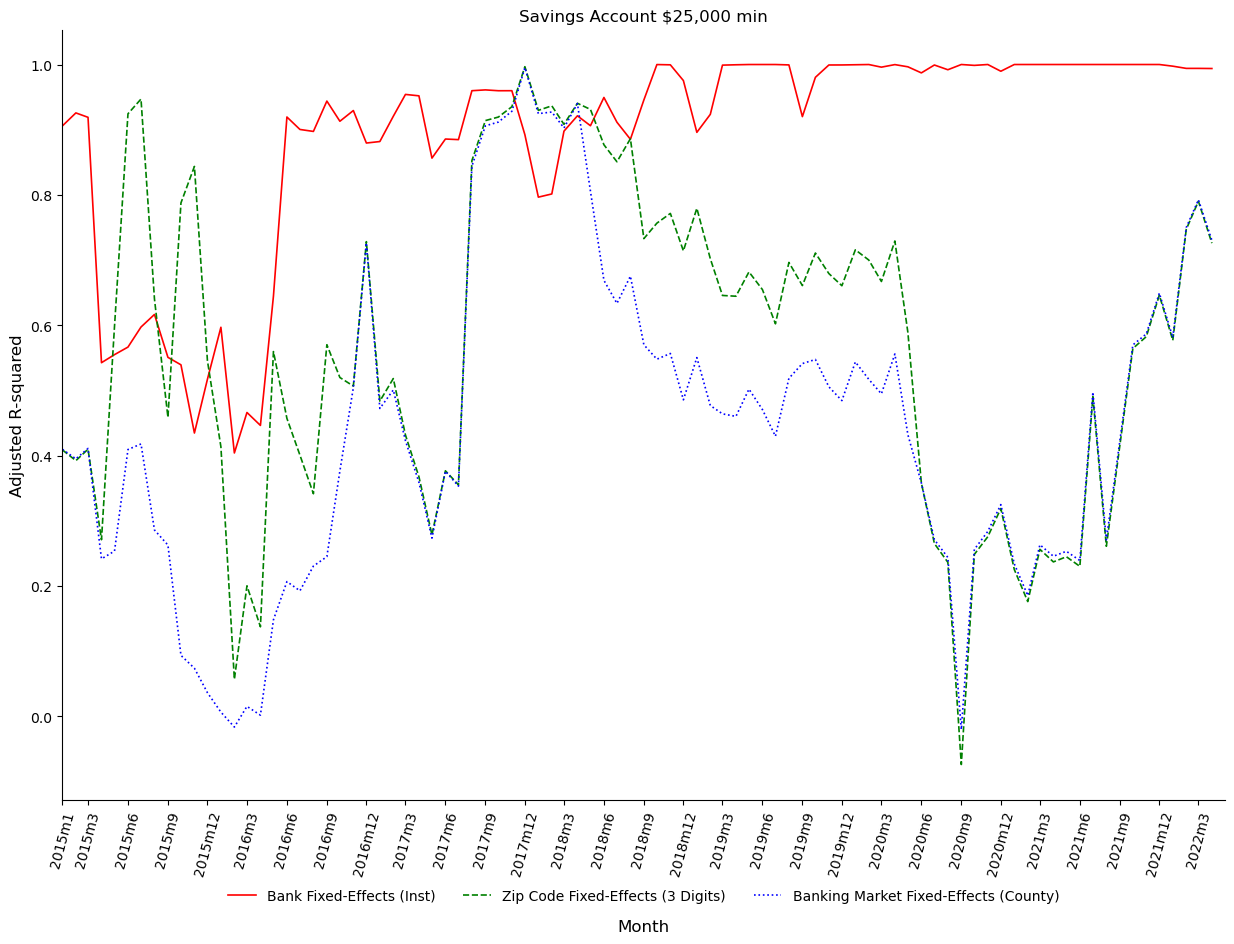

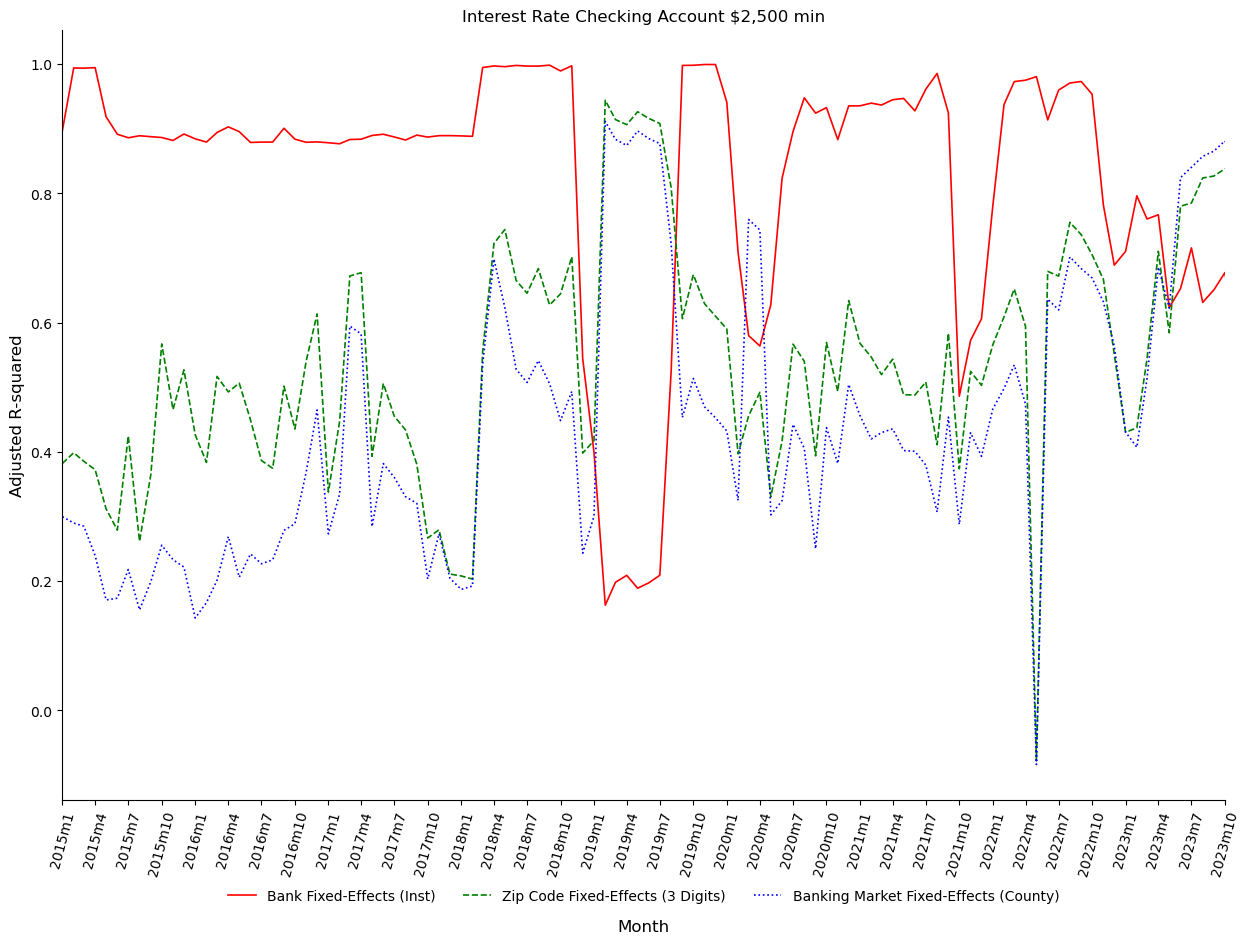

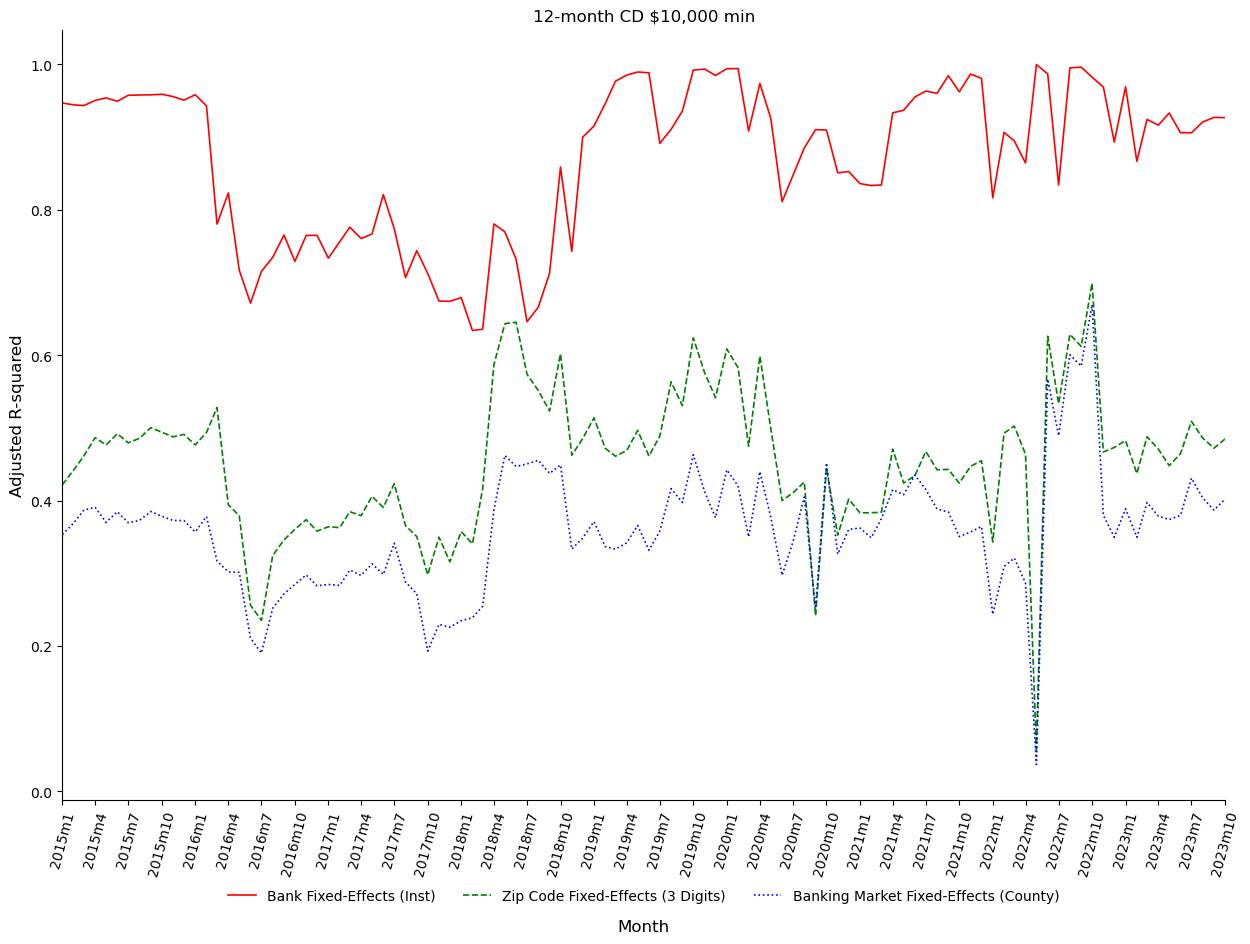

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import platform  # Used to determine the operating system

# Mapping of file names to chart titles
file_mapping = {
    "SAV2_5K_reg_results.csv": "Savings Account $2,500 min",
    "SAV25K_reg_results.csv": "Savings Account $25,000 min",
    "INTCK2_5K_reg_results.csv": "Interest Rate Checking Account $2,500 min",
    "12MCD10K_reg_results.csv": "12-month CD $10,000 min"
}

# Paths for data files and figure storage
data_path = "../data/final/reg_results_multi_branch_sample_932466/"
figure_path = "../figure/multi_branch_sample_932466/"

# Set X-axis date format based on the operating system 
# (Linux/macOS uses "%Y-%-m", Windows uses "%Y-%#m")
if platform.system() == "Windows":
    date_format = "%Ym%#m"
else:
    date_format = "%Ym%-m"

# Custom date parsing function
def parse_date(x):
    # Return NaT if x is empty or "nan" (string form)
    if pd.isna(x) or str(x).strip().lower() in ["nan", ""]:
        return pd.NaT
    # Trim spaces and trailing slashes (e.g., "2023/6/" -> "2023/6")
    x = str(x).strip().rstrip("/")
    # If '-' is present, determine the format
    if '-' in x:
        # If the first two characters are digits (e.g., "15-Jan"), use "%y-%b"
        if x[:2].isdigit():
            try:
                return pd.to_datetime(x, format="%y-%b")
            except ValueError as e:
                print(f"Failed to parse '{x}' with format '%y-%b': {e}")
                return pd.NaT
        # Otherwise, try "%b-%y" (e.g., "Jan-15")
        else:
            try:
                return pd.to_datetime(x, format="%b-%y")
            except ValueError as e:
                print(f"Failed to parse '{x}' with format '%b-%y': {e}")
                return pd.NaT
    # If '/' is present, assume format "%Y/%m" (e.g., "2023/6")
    elif '/' in x:
        try:
            return pd.to_datetime(x, format="%Y/%m")
        except ValueError as e:
            print(f"Failed to parse '{x}' with format '%Y/%m': {e}")
            return pd.NaT
    else:
        print(f"Unrecognized date format: '{x}'")
        return pd.NaT

# Iterate over all files and generate charts
for file_name, title in file_mapping.items():
    # Read data as strings to prevent automatic format conversion issues
    raw_data = pd.read_csv(f"{data_path}{file_name}", dtype=str)
    
    # Identify the last completely non-empty row and keep only rows before it
    nan_row_index = raw_data.dropna(how="all").index[-1]
    data = raw_data.loc[:nan_row_index].reset_index(drop=True)

    # Convert 'month' column to string and remove rows starting with "AVG"
    data["month"] = data["month"].astype(str)
    data = data[~data["month"].str.startswith("AVG", na=False)].reset_index(drop=True)

    # Convert numerical columns to float and drop rows where 'month' is missing
    data.iloc[:, 1:] = data.iloc[:, 1:].astype(float)
    data = data.dropna(subset=["month"])
    
    # Parse the 'month' column using the custom function
    data["month"] = data["month"].apply(parse_date)
    # Remove rows where parsing failed
    data = data.dropna(subset=["month"]).reset_index(drop=True)
    
    # Ensure all dates are successfully parsed
    if data["month"].isnull().any():
        raise ValueError("Some dates could not be parsed. Please check the data!")

    # Sort data by 'month' in ascending order before plotting
    data = data.sort_values(by="month").reset_index(drop=True)

    # Create a line plot
    fig, ax = plt.subplots(figsize=(15, 10))

    # Plot the time series for different fixed effects
    ax.plot(data["month"], data["r2_inst"], color="red", linestyle="-", linewidth=1.2, label="Bank Fixed-Effects (Inst)")
    ax.plot(data["month"], data["r2_zip3"], color="green", linestyle="--", linewidth=1.2, label="Zip Code Fixed-Effects (3 Digits)")
    ax.plot(data["month"], data["r2_county"], color="blue", linestyle=":", linewidth=1.2, label="Banking Market Fixed-Effects (County)")

    # Keep only the left and bottom axis lines
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    # Set X-axis ticks: one every 3 months with the specified format
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter(date_format))

    # Set X-axis range: starting from "2015-01-01" to the second-to-last data point
    start_date = pd.Timestamp("2015-01-01")
    end_date = data["month"].iloc[-2]
    ax.set_xlim([start_date, end_date])

    # Adjust X-axis ticks to ensure the start date is included
    xticks = list(ax.get_xticks())
    start_num = mdates.date2num(start_date)
    if start_num not in xticks:
        xticks = [start_num] + [tick for tick in xticks if tick >= mdates.date2num(data["month"].iloc[0])]
        ax.set_xticks(xticks)

    # Rotate X-axis labels to prevent overlap
    plt.xticks(rotation=75, fontsize=10)

    # Set legend position
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False)

    # Set axis labels and title
    ax.set_xlabel("Month", fontsize=12, labelpad=30)
    ax.set_ylabel("Adjusted R-squared", fontsize=12)
    ax.set_title(title, fontsize=12)

    # Save the figure as a PDF and display it
    save_file = f"{figure_path}{file_name.replace('_reg_results.csv', '')}_adjusted_R2_Rate_3_fixed_effects.pdf"
    plt.savefig(save_file, format="pdf", bbox_inches="tight")
    plt.show()

In [9]:
data.columns

Index(['month', 'r2_inst', 'r2_primarycompany', 'r2_zip9', 'r2_zip5',
       'r2_zip3', 'r2_msa', 'r2_cbsa', 'r2_county'],
      dtype='object')

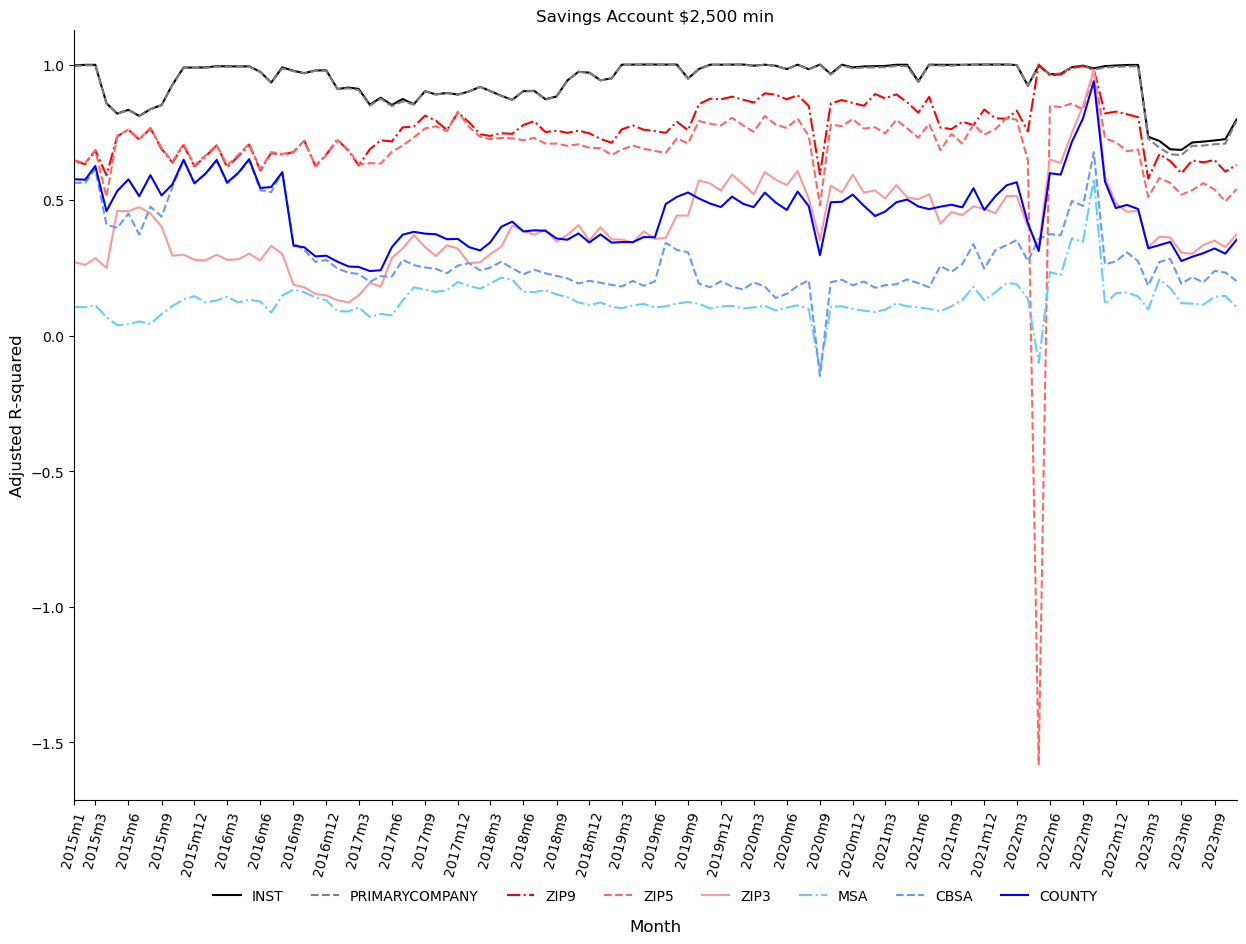

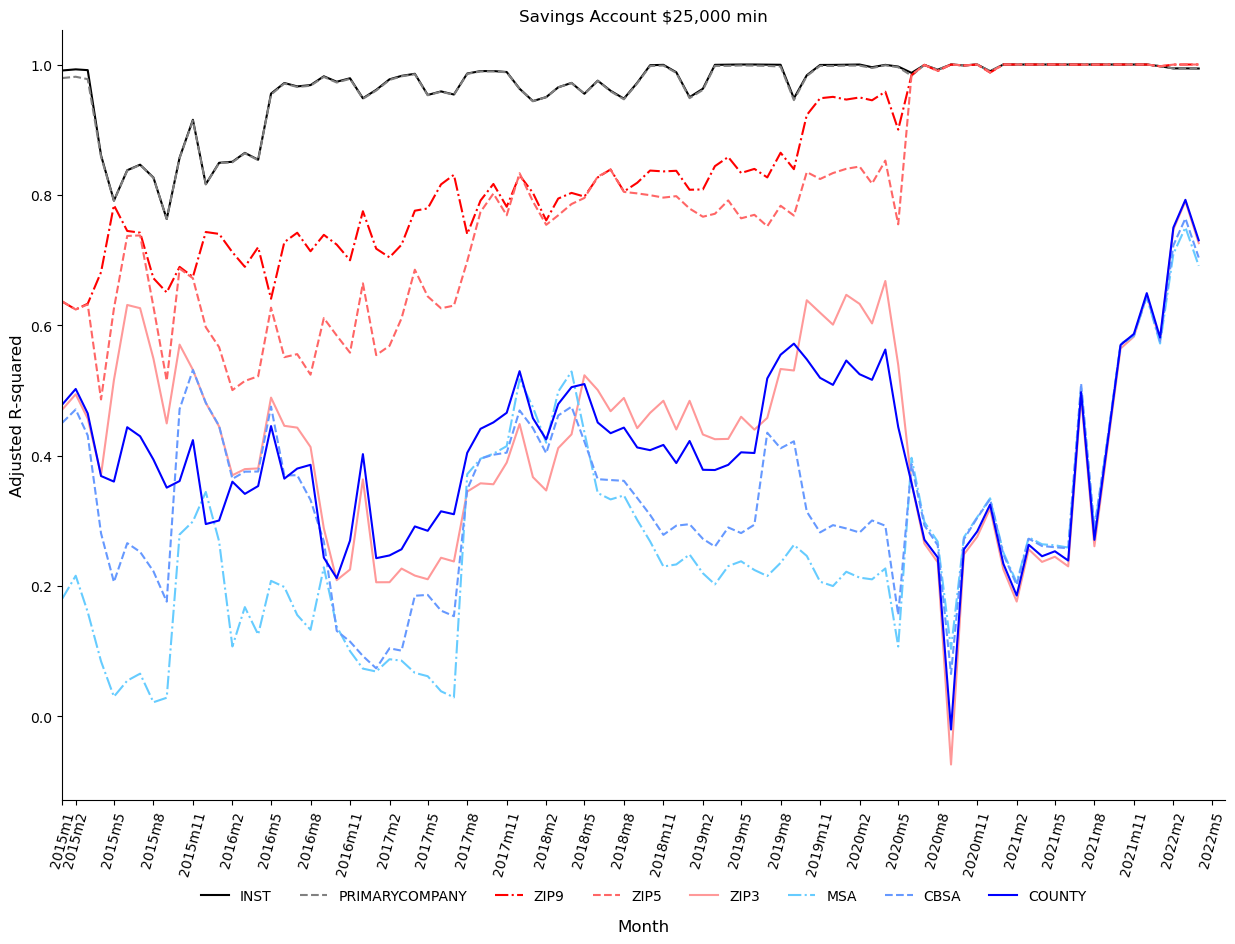

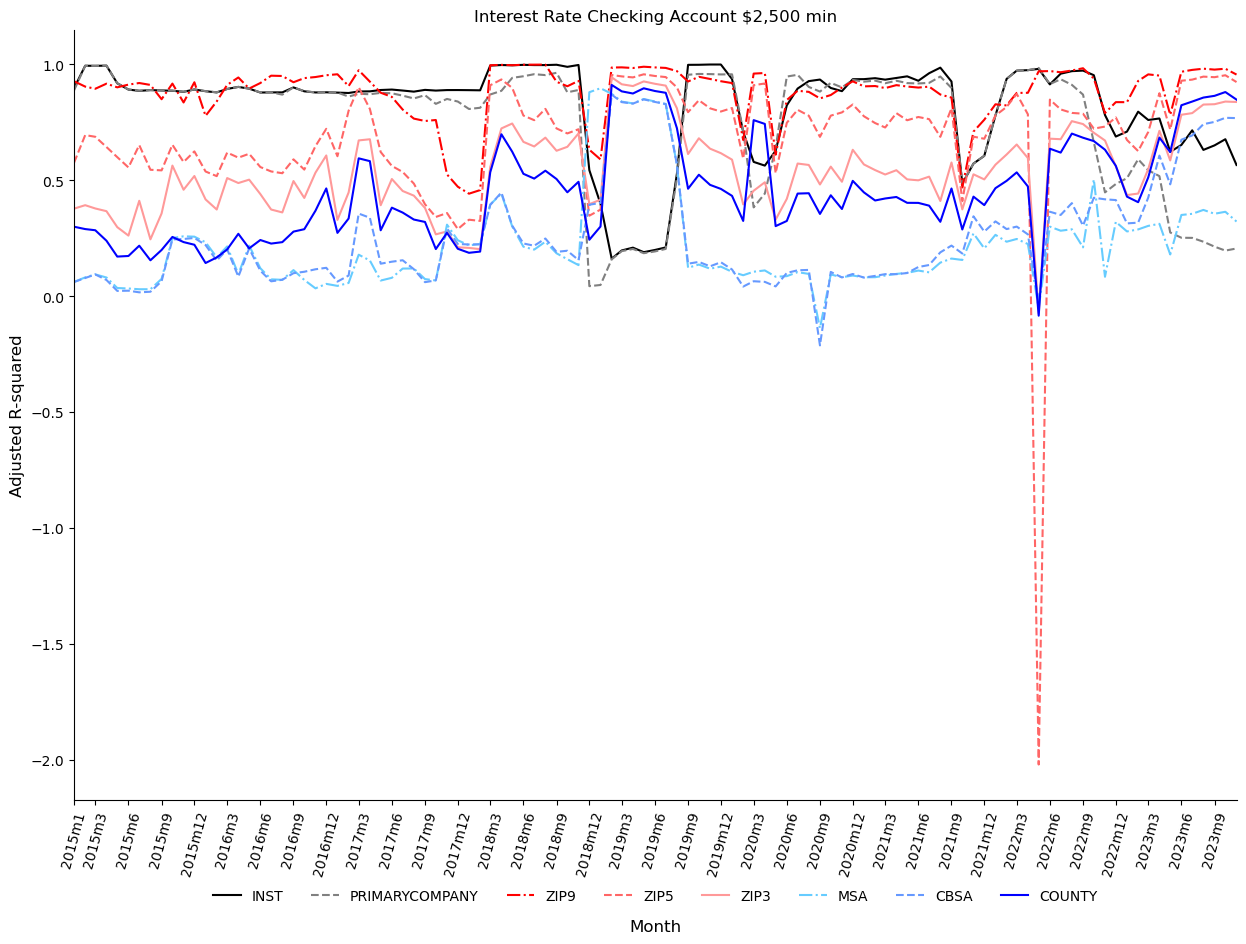

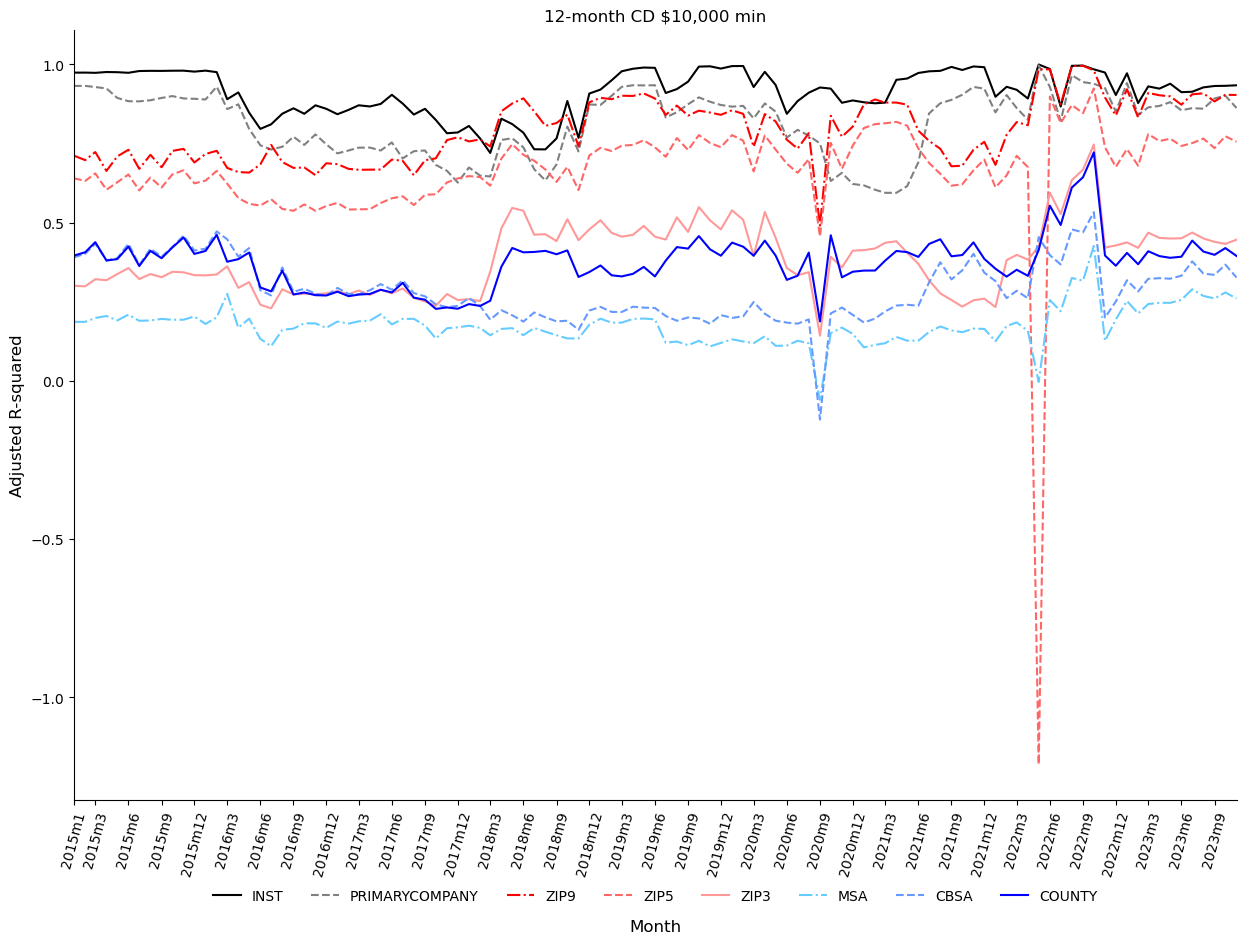

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import platform  # Used to determine the operating system

# Mapping of filenames to corresponding chart titles
file_mapping = {
    "SAV2_5K_reg_results.csv": "Savings Account $2,500 min",
    "SAV25K_reg_results.csv": "Savings Account $25,000 min",
    "INTCK2_5K_reg_results.csv": "Interest Rate Checking Account $2,500 min",
    "12MCD10K_reg_results.csv": "12-month CD $10,000 min"
}

# Color mapping (Zip Code-related in red with different shades; MSA & CBSA in blue; Bank in black)
color_mapping = {
    "r2_inst": "black",
    "r2_primarycompany": "grey",
    "r2_zip9": "#FF0000",   # Dark red
    "r2_zip5": "#FF6666",   # Medium red
    "r2_zip3": "#FF9999",   # Light red
    "r2_msa": "#66CCFF",    # Sky blue
    "r2_cbsa": "#6699FF",    # Light blue
    "r2_county": "#0000FF"   # Dark blue
}

# Line style mapping
linestyle_mapping = {
    "r2_inst": "-",
    "r2_primarycompany": "--",
    "r2_zip9": "-.",
    "r2_zip5": "--",
    "r2_zip3": "-",  
    "r2_msa": "-.",
    "r2_cbsa": "--",
    "r2_county":"-"
}

# Data file path
data_path = "../data/final/reg_results_all_sample_939605/"
# Path to save charts
figure_path = "../figure/all_sample_939605/all_fixed_effects/"

# Fix the X-axis start date to January 1, 2015
start_date = pd.Timestamp("2015-01-01")

# Determine the operating system (Linux/macOS uses "%Y-%-m", Windows uses "%Y-%#m")
if platform.system() == "Windows":
    date_format = "%Ym%#m"
else:
    date_format = "%Ym%-m"

# Custom date parsing function
def parse_date(x):
    # Return NaT if x is empty or "nan" (string form)
    if pd.isna(x) or str(x).strip().lower() in ["nan", ""]:
        return pd.NaT
    # Trim spaces and trailing slashes (e.g., "2023/6/" -> "2023/6")
    x = str(x).strip().rstrip("/")
    # If '-' is present, determine the format
    if '-' in x:
        # If the first two characters are digits (e.g., "15-Jan"), use "%y-%b"
        if x[:2].isdigit():
            try:
                return pd.to_datetime(x, format="%y-%b")
            except ValueError as e:
                print(f"Failed to parse '{x}' with format '%y-%b': {e}")
                return pd.NaT
        # Otherwise, try "%b-%y" (e.g., "Jan-15")
        else:
            try:
                return pd.to_datetime(x, format="%b-%y")
            except ValueError as e:
                print(f"Failed to parse '{x}' with format '%b-%y': {e}")
                return pd.NaT
    # If '/' is present, assume format "%Y/%m" (e.g., "2023/6")
    elif '/' in x:
        try:
            return pd.to_datetime(x, format="%Y/%m")
        except ValueError as e:
            print(f"Failed to parse '{x}' with format '%Y/%m': {e}")
            return pd.NaT
    else:
        print(f"Unrecognized date format: '{x}'")
        return pd.NaT

# Iterate over all files and generate corresponding charts
for file_name, title in file_mapping.items():
    # Read data as string to prevent auto-conversion issues
    data = pd.read_csv(f"{data_path}{file_name}", dtype=str)  

    # Remove rows where 'month' starts with "AVG"
    data = data[~data["month"].str.startswith("AVG", na=False)].reset_index(drop=True)

    # Parse the 'month' column using the custom function
    data["month"] = data["month"].apply(parse_date)
    
    # Remove rows where parsing failed
    data = data.dropna(subset=["month"]).reset_index(drop=True)
    
    # Ensure all dates are successfully parsed
    if data["month"].isnull().any():
        raise ValueError("Some dates could not be parsed. Please check the data!")

    # Sort data by 'month' in ascending order
    data = data.sort_values(by="month").reset_index(drop=True)

    # Set the X-axis start point
    data = data[data["month"] >= start_date]  # Keep only data from January 1, 2015, onwards

    # Convert numerical columns to float
    data.iloc[:, 1:] = data.iloc[:, 1:].astype(float)

    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 10))

    # Iterate over all columns to be plotted
    for col in ["r2_inst", "r2_primarycompany", "r2_zip9", "r2_zip5", "r2_zip3", "r2_msa", "r2_cbsa", "r2_county"]:
        if col in data.columns:  # Ensure the column exists
            ax.plot(data["month"], data[col], 
                    color=color_mapping[col], linestyle=linestyle_mapping[col], linewidth=1.5, label=col.replace("r2_", "").upper())

    # Keep only the left and bottom axes
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    # Display an X-axis tick every 3 months
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter(date_format))  # Format without leading zero

    # Fix the X-axis range
    end_date = data["month"].max() if not data["month"].isna().all() else start_date  # Avoid issues with empty data
    ax.set_xlim([start_date, end_date])

    # Ensure '2015-1' is always present on the X-axis
    xticks = list(ax.get_xticks())
    start_num = mdates.date2num(start_date)
    if start_num not in xticks:
        xticks = [start_num] + [tick for tick in xticks if tick >= mdates.date2num(data["month"].iloc[0])]
        ax.set_xticks(xticks)

    # Rotate X-axis labels 75°
    plt.xticks(rotation=75, fontsize=10)

    # Adjust legend: one row, positioned below the chart
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=8, frameon=False)

    # Set axis labels
    ax.set_xlabel("Month", fontsize=12, labelpad=30)
    ax.set_ylabel("Adjusted R-squared", fontsize=12)

    # Set chart title
    ax.set_title(title, fontsize=12)

    # Save the image
    save_file = f"{figure_path}{file_name.replace('_reg_results.csv', '')}_adjusted_R2_all_fixed_effects.pdf"
    plt.savefig(save_file, format="pdf", bbox_inches="tight")

    # Display the image
    plt.show()